In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import pad_sequences
from collections import Counter
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM, Embedding
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.models import load_model
from math import sqrt
import string
# from nltk.corpus import stopwords
import time
import sys
# import nltk

# nltk.download('stopwords')

2023-03-30 09:02:13.306935: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-30 09:02:13.439091: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-30 09:02:14.213026: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-30 09:02:14.213097: W tensorflow/

In [2]:
data = pd.read_csv('/root/autodl-fs/review_rating.csv')

In [3]:
data  = data[:100000]
data

,Unnamed: 0,review_body,star_rating
0,1,"As a family allergic to wheat, dairy, eggs, nu...",5
1,2,"My favorite nut. Creamy, crunchy, salty, and ...",5
2,3,This green tea tastes so good! My girlfriend l...,5
3,4,I love Melissa's brand but this is a great sec...,5
4,5,good,5
...,...,...,...
99995,99996,This is absolutely the most savory brittle I h...,5
99996,99997,Exactly what I wanted,5
99997,99998,Not impressed,1
99998,99999,Yummy.,5


In [4]:
#convert into numpy arrays
# reviews = data[["review_body"]]
reviews = data.review_body.astype("str")
ratings = data.star_rating.values
reviews[0]

"As a family allergic to wheat, dairy, eggs, nuts, and several other things, we love the entire Cravings Place line of products as it allows us to bake treats with minimal effort and ingredients. Most allergy-free and gluten-free mixes usually just omit one or two allergens at most, so it's great to see a mix created without many of the most common allergens. (Note these still have soy and corn). We consume these on a regular basis and have been doing so for years."

In [5]:
#data preprocessing
rating_count = Counter()
for rating in ratings:
    rating_count[rating]+=1

#initialize 'num_min' with the value of rating_count's key = '1'.
num_min = rating_count[1]
for k in rating_count:
    if rating_count[k]<=num_min:
        num_min = rating_count[k]

print(rating_count,num_min)

#truncate the data to have equal amount across all ratings.
# one,two,three,four,five = 0,0,0,0,0
rating_list = np.array([0,0,0,0,0]) #namely rating = 1,2,3,4,5
end = np.array([num_min,num_min,num_min,num_min,num_min])
correct = np.array([1,1,1,1,1])
# a = rating_list/end
# print(rating_list/end == correct)
# sys.exit()
rev,ra = [],[]

for j,rating in enumerate(ratings):
    if all(rating_list == end):
        break

    for i,v in enumerate(rating_list):
        if v<num_min and i+1==rating:
            rev.append(reviews[j])
            ra.append(rating)
            rating_list[i]+=1

len(rev),len(ra)        
# reviews.shape,ratings.shape
reviews = np.array(rev)
ratings = np.array(ra)
# reviews = rev
# ratings = ra

Counter({5: 71603, 4: 11024, 1: 7079, 3: 6283, 2: 4011}) 4011


In [6]:
#remove punctuation and stop words
#lower case
# stop = stopwords.words('english')
for i,text in enumerate(reviews):
    reviews[i] = ' '.join([word.strip(string.punctuation).lower() for word in text.split(" ") if len(word) > 0])
   

reviews[0]

"as a family allergic to wheat dairy eggs nuts and several other things we love the entire cravings place line of products as it allows us to bake treats with minimal effort and ingredients most allergy-free and gluten-free mixes usually just omit one or two allergens at most so it's great to see a mix created without many of the most common allergens note these still have soy and corn we consume these on a regular basis and have been doing so for years"

In [7]:
count = Counter()
for review in reviews:
    for word in str(review).split():
        count[word]+=1

num_words = len(count)
print(num_words)
# count

24382


In [8]:
max_len = 300

tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(reviews)
word_index = tokenizer.word_index
len(word_index)

18069

In [9]:
review_to_seq = tokenizer.texts_to_sequences(reviews)
review_to_seq[1]

[15, 194, 813, 681, 526, 361, 3, 496, 111, 57, 52, 117, 26, 1370, 11]

In [10]:
reviews[0]

"as a family allergic to wheat dairy eggs nuts and several other things we love the entire cravings place line of products as it allows us to bake treats with minimal effort and ingredients most allergy-free and gluten-free mixes usually just omit one or two allergens at most so it's great to see a mix created without many of the most common allergens note these still have soy and corn we consume these on a regular basis and have been doing so for years"

In [11]:
padded_reviews = pad_sequences(review_to_seq, maxlen=max_len)
padded_reviews[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [12]:
train_data = padded_reviews[:int(0.8*padded_reviews.shape[0])]
test_data = padded_reviews[int(0.8*padded_reviews.shape[0]):]
train_target = ratings[:int(0.8*ratings.shape[0])]
test_target = ratings[int(0.8*ratings.shape[0]):]
train_data.shape,test_data.shape,train_target.shape,test_target.shape

((16044, 300), (4011, 300), (16044,), (4011,))

In [13]:
## LSTM model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(len(word_index)+1, embedding_vecor_length, input_length=max_len))
model.add(LSTM(150))
model.add(Dropout(rate=0.2))

model.add(Dense(50, activation='tanh'))
model.add(Dense(1, activation='linear'))
print(model.summary())


# ## LSTM model
# embedding_vecor_length = 32
# model = Sequential()
# model.add(Embedding(len(word_index)+1, embedding_vecor_length, input_length=max_len))
# model.add(Dropout(0.2))
# model.add(LSTM(150, return_sequences=True))
# model.add(Dropout(rate=0.2))
# model.add(LSTM(100))
# model.add(Dropout(rate=0.2))

# model.add(Dense(50, activation='tanh'))
# model.add(Dense(1, activation='linear'))
# print(model.summary())

2023-03-30 09:03:05.113198: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-30 09:03:05.685363: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22294 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:56:00.0, compute capability: 8.6


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 32)           578240    
                                                                 
 lstm (LSTM)                 (None, 150)               109800    
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense (Dense)               (None, 50)                7550      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 695,641
Trainable params: 695,641
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
start = time.time()
adam = Adam(learning_rate = 1e-3)
model.compile(loss='mean_squared_error', optimizer=adam)
checkpointer = ModelCheckpoint(filepath="./lstm.hdf5", verbose=0, save_best_only=True)
m = model.fit(
            train_data,
            train_target,
            batch_size=256,
            verbose=1,
            epochs=10,
            validation_split=0.2,
            shuffle=True, 
            callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)

Epoch 1/10
51/51 [==============================] - 10s 160ms/step - loss: 0.7068 - val_loss: 1.7474
Epoch 2/10
51/51 [==============================] - 7s 136ms/step - loss: 0.4999 - val_loss: 1.5749
Epoch 3/10
51/51 [==============================] - 7s 140ms/step - loss: 0.4659 - val_loss: 1.4708
Epoch 4/10
51/51 [==============================] - 6s 126ms/step - loss: 0.4357 - val_loss: 1.3725
Epoch 5/10
51/51 [==============================] - 6s 119ms/step - loss: 0.4063 - val_loss: 1.4876
Epoch 6/10
51/51 [==============================] - 6s 125ms/step - loss: 0.3959 - val_loss: 1.7827
Epoch 7/10
51/51 [==============================] - 6s 124ms/step - loss: 0.3601 - val_loss: 1.6006
Epoch 8/10
51/51 [==============================] - 5s 107ms/step - loss: 0.3325 - val_loss: 1.6855
Epoch 9/10
51/51 [==============================] - 4s 82ms/step - loss: 0.3146 - val_loss: 1.6130
Epoch 10/10
51/51 [==============================] - 4s 75ms/step - loss: 0.3115 - val_loss: 1.6459


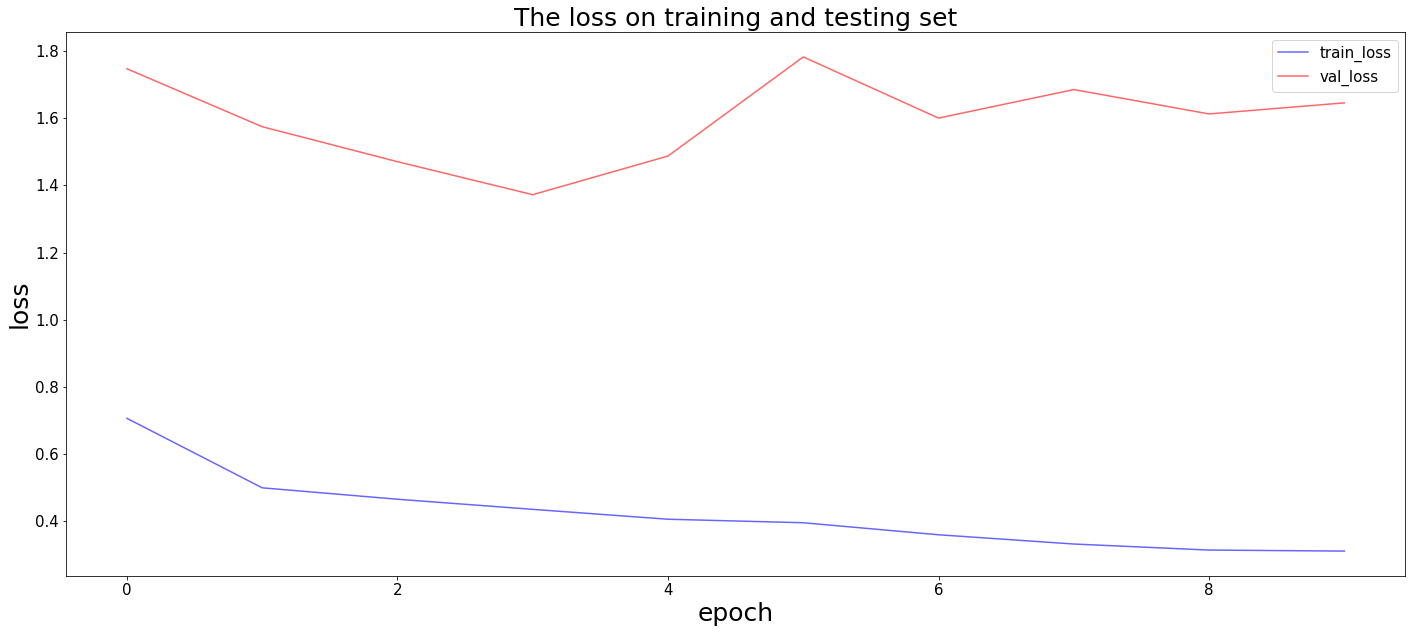

In [27]:
def plot_losses(train_loss, val_loss):
    plt.rcParams["figure.figsize"] = [24,10]
    plt.title('The loss on training and testing set',fontsize=25)
    plt.plot( range(len(train_loss)), train_loss, color = 'b', alpha = 0.6, label='train_loss' )
    plt.plot( range(len( val_loss )), val_loss, color = 'r', alpha = 0.6, label='val_loss' )
    plt.xlabel( 'epoch',fontsize=25 )
    plt.ylabel( 'loss',fontsize=25 )
    plt.xticks(fontsize=15 )
    plt.yticks(fontsize=15 )
    plt.legend(fontsize=15 )

train_loss = m.history['loss']
val_loss = m.history['val_loss']

plot_losses(train_loss, val_loss)

In [28]:
model_path = "./lstm.hdf5"
model = load_model(model_path)

pred = model.predict(test_data).reshape(-1)

126/126 [==============================] - 1s 7ms/step


In [29]:
i = 270
print(pred[i])
print(test_target[i])

2.8136144
1


In [30]:
def rmse_loss(y_predict, y):
    return sqrt(np.mean(np.square(y_predict - y))) 

def mae_loss(y_predict, y):
    return np.mean(np.abs(y_predict - y))

rmse_loss = rmse_loss(pred, test_target)
mae_loss = mae_loss(pred, test_target)
print('Root Mean square error on test set: ', rmse_loss)
print('Mean absolute error on the test set: ', mae_loss)
# Root Mean square error on test set:  1.1204180827539099
# Mean absolute error on the test set:  0.7932159740924836

##without data clearing:
##lr = 1e-3, units = (150), batch size  = 256, without dropout
# Root Mean square error on test set:  1.0175565538670552
# Mean absolute error on the test set:  0.8108590628726097

##lr = 1e-3, units = (150,50), batch size  = 256, without dropout
# Root Mean square error on test set:  0.9325924144334593
# Mean absolute error on the test set:  0.7423570203898803

#with data clearning:
#lr = 1e-3, units = (150,50), batch size  = 256, without dropout
# Root Mean square error on test set:  0.802034505930432
# Mean absolute error on the test set:  0.4409213175147772

#lr = 1e-3, units = (150,50), batch size  = 256, dropout = 0.2
# Root Mean square error on test set:  0.7803943854060685
# Mean absolute error on the test set:  0.447297577457875

Root Mean square error on test set:  1.1055313913459164
Mean absolute error on the test set:  0.8819430236231208


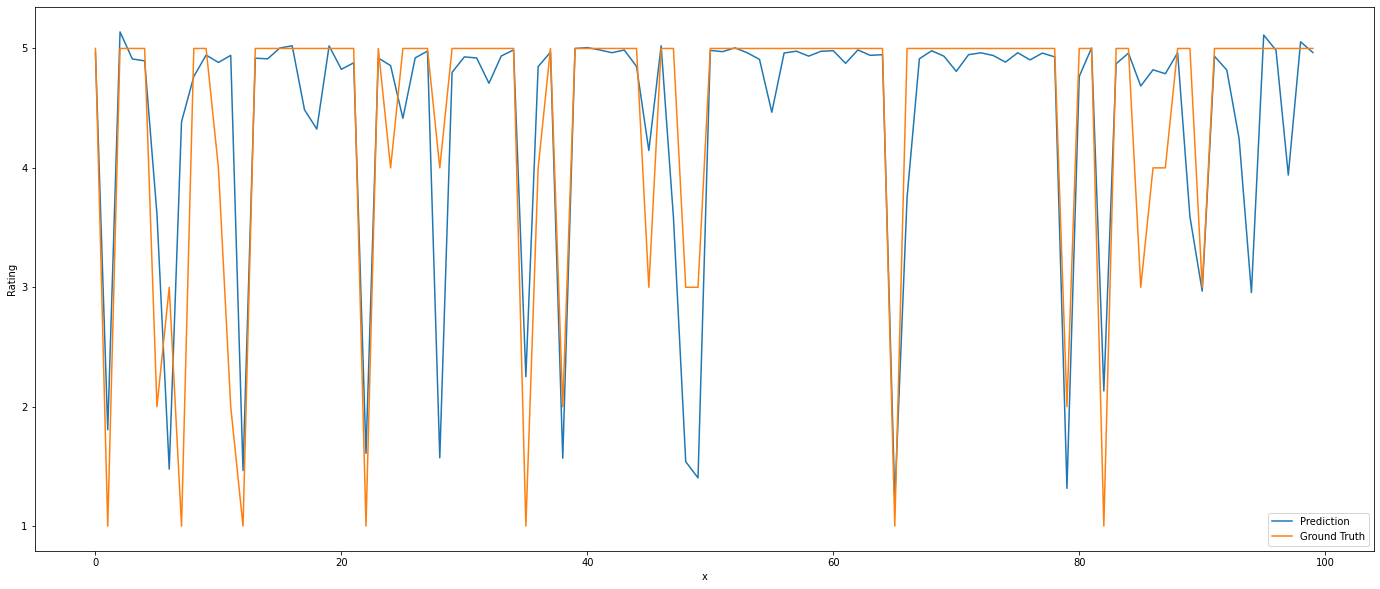

In [86]:
fig, axes = plt.subplots(figsize=(24, 10) )
rng = 100
prediction = pred[:rng]
actual = test_target[:rng]
axes.plot(prediction, label = 'Prediction')
axes.plot(actual, label = 'Ground Truth')
plt.xlabel('x')
plt.ylabel('Rating')
plt.legend()

## As shown in the plot, the model seems to have a good prediction on high ratings, this may due to the larger
##number of high ratings sample in the dataset

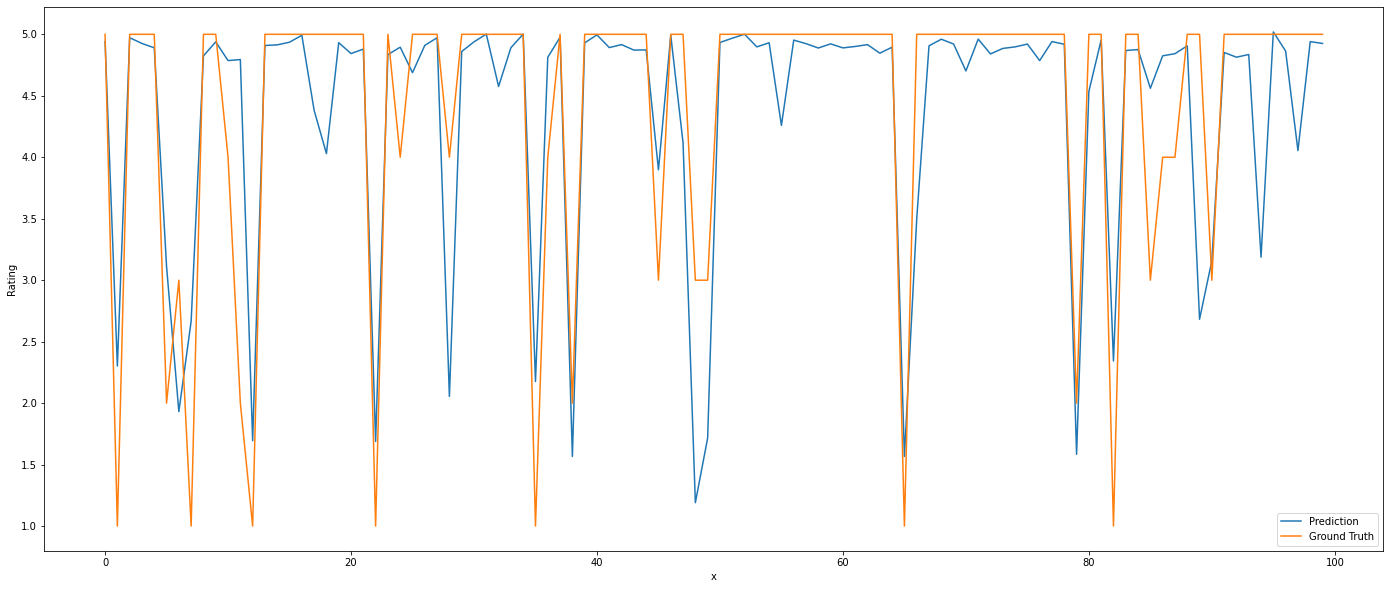

In [93]:
fig, axes = plt.subplots(figsize=(24, 10) )
rng = 100
prediction = pred[:rng]
actual = test_target[:rng]
axes.plot(prediction, label = 'Prediction')
axes.plot(actual, label = 'Ground Truth')
plt.xlabel('x')
plt.ylabel('Rating')
plt.legend()